# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

We're using TF 1.13.1


In [2]:
import sys
sys.path.append("..")
sys.path.append("SupportFunctions")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

from keras.datasets import mnist

Using TensorFlow backend.


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [3]:
grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
                        all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [4]:
# token expires every 30 min
COURSERA_TOKEN = "DdAr9jWIb0pvjPGU"
COURSERA_EMAIL = "camfincher@hotmail.com"

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [5]:
def load_dataset_mnist(flatten=False):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset_mnist()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


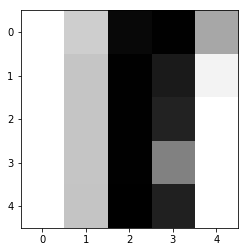

And the whole sample:


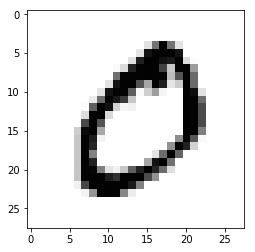

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [7]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [8]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [9]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [10]:
# run this again if you remake your graph
s = reset_tf_session()

In [11]:
# Model parameters: W and b
#tf.get_variable(...) with shape[0] = 784, it may have to be shape = (784,10)
W = tf.get_variable("W", shape = [784,10], dtype=tf.float32, trainable=True)  
#Below mihgt nieed to be shape 10, for eaach intercept
b = tf.get_variable("b", shape =[10], dtype = tf.float32, trainable = True)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# Placeholders for the input data

# tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_X = tf.placeholder(shape = [None,784], dtype = tf.float32, name = 'input_X')
# tf.placeholder(...) for one-hot encoded true labels
input_y = tf.placeholder(shape = [None,10], dtype = tf.int16, name = 'input_y') 

In [13]:
# Compute predictions
# logits for input_X, resulting shape should be [input_X.shape[0], 10]
logits =  tf.matmul(input_X , W) + b

# apply tf.nn.softmax to logits
probas = tf.nn.softmax(logits) 

# apply tf.argmax to find a class index with highest probability
classes = tf.argmax(probas, axis = 1)

In [14]:


# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = input_y, logits = logits)) #cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [15]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        batch_loss, _ = s.run([loss, step], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    print(epoch, "Train accuracy:", train_accuracy, "Test accuracy:", valid_accuracy)
 #   simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

0 Train accuracy: 0.83666 Test accuracy: 0.8578
1 Train accuracy: 0.87162 Test accuracy: 0.887
2 Train accuracy: 0.88644 Test accuracy: 0.8987
3 Train accuracy: 0.89586 Test accuracy: 0.9057
4 Train accuracy: 0.90066 Test accuracy: 0.9089
5 Train accuracy: 0.9054 Test accuracy: 0.912
6 Train accuracy: 0.90812 Test accuracy: 0.9144
7 Train accuracy: 0.9106 Test accuracy: 0.9162
8 Train accuracy: 0.91234 Test accuracy: 0.9188
9 Train accuracy: 0.91408 Test accuracy: 0.9196
10 Train accuracy: 0.9156 Test accuracy: 0.9216
11 Train accuracy: 0.91708 Test accuracy: 0.9224
12 Train accuracy: 0.91814 Test accuracy: 0.923
13 Train accuracy: 0.91924 Test accuracy: 0.9234
14 Train accuracy: 0.92014 Test accuracy: 0.9245
15 Train accuracy: 0.92094 Test accuracy: 0.9255
16 Train accuracy: 0.92152 Test accuracy: 0.9258
17 Train accuracy: 0.92224 Test accuracy: 0.9262
18 Train accuracy: 0.923 Test accuracy: 0.9263
19 Train accuracy: 0.92372 Test accuracy: 0.9268
20 Train accuracy: 0.92418 Test accura

# Submit a linear model

In [16]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([W, b, input_X, input_y, logits, probas, classes]))
# Validation loss
grader.set_answer("vmogZ", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy
grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [17]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [22]:
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.

#Initilizing
s = reset_tf_session()

#Creating our inputs
# tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_X = tf.placeholder(shape = [None,784], dtype = tf.float32, name = 'input_X')
# tf.placeholder(...) for one-hot encoded true labels
input_y = tf.placeholder(shape = [None,10], dtype = tf.int16, name = 'input_y') 
#creating our hidden layer :P with said calculations

Layer1 = tf.layers.dense(input_X, 256, activation=tf.nn.sigmoid)
Layer2 = tf.layers.dense(Layer1, 256, activation=tf.nn.sigmoid)
logits = tf.layers.dense(Layer2, 10, activation=tf.nn.sigmoid)

# apply tf.nn.softmax to logits
probas = tf.nn.softmax(logits) 

# apply tf.argmax to find a class index with highest probability
classes = tf.argmax(probas, axis = 1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = input_y, logits = logits)) #cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer().minimize(loss)

In [23]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        batch_loss, _ = s.run([loss, step], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    print(epoch, "Train accuracy:", train_accuracy, "Test accuracy:", valid_accuracy)
 #   simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

0 Train accuracy: 0.85058 Test accuracy: 0.8666
1 Train accuracy: 0.88664 Test accuracy: 0.8975
2 Train accuracy: 0.90798 Test accuracy: 0.9137
3 Train accuracy: 0.91954 Test accuracy: 0.9247
4 Train accuracy: 0.92718 Test accuracy: 0.9307
5 Train accuracy: 0.933 Test accuracy: 0.9344
6 Train accuracy: 0.93784 Test accuracy: 0.9392
7 Train accuracy: 0.94214 Test accuracy: 0.9438
8 Train accuracy: 0.94582 Test accuracy: 0.9465
9 Train accuracy: 0.94928 Test accuracy: 0.9502
10 Train accuracy: 0.95234 Test accuracy: 0.9528
11 Train accuracy: 0.95526 Test accuracy: 0.9559
12 Train accuracy: 0.95798 Test accuracy: 0.9578
13 Train accuracy: 0.96042 Test accuracy: 0.9597
14 Train accuracy: 0.96276 Test accuracy: 0.9625
15 Train accuracy: 0.96494 Test accuracy: 0.9637
16 Train accuracy: 0.96702 Test accuracy: 0.9645
17 Train accuracy: 0.96912 Test accuracy: 0.9652
18 Train accuracy: 0.97072 Test accuracy: 0.9661
19 Train accuracy: 0.97262 Test accuracy: 0.9672
20 Train accuracy: 0.9743 Test a

# Submit the MLP with 2 hidden layers
Run these cells after training the MLP with 2 hidden layers

In [24]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy for MLP
grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [25]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [ ]:
dd